In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import chainer
import os
import time
import glob
from chainer import cuda, Function, Variable, optimizers, serializers, utils, initializers
from chainer import Link, Chain, ChainList
import chainer.links as L
import chainer.functions as F

from distill import DistillPredictor

In [2]:
out_dir = 'backup/'
os.makedirs(out_dir, exist_ok=True)

## Load mnist dataset and create data iterators

In [3]:
train, test = chainer.datasets.get_mnist()

In [4]:
n_cls = 10
train_num = len(train)
test_num = len(test)
print('train num:%d, test num:%d' % (train_num, test_num))

train_iter = chainer.iterators.SerialIterator(train, 256)
test_iter = chainer.iterators.SerialIterator(test, 1000, repeat=False, shuffle=False)

train num:60000, test num:10000


## Define teacher and student model 

In [5]:
class teacherNet(Chain):
    def __init__(self):
        super(teacherNet, self).__init__(
            fc1 = L.Linear(28 * 28, 800),
            fc2 = L.Linear(800, 800),
            fc3 = L.Linear(800, 10),
        )
        
    def __call__(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class studentNet(Chain):
    def __init__(self):
        super(studentNet, self).__init__(
            fc1 = L.Linear(28 * 28, 8),
            fc2 = L.Linear(8, 8),
            fc3 = L.Linear(8, 10),
        )
    def __call__(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train

In [6]:
def train_model(model, optimizer, train_iter, test_iter, max_iters, out_dir, out_name):
    ts = time.strftime("%Y%m%d%H%M",time.localtime())
    model.predictor.train = True
    cuda.get_device(0).use()
    model.to_gpu()
    # begin training
    for iters in range(max_iters):
        model.predictor.train = True
        batch = train_iter.next()
        x_data = np.array([x[0] for x in batch])
        t = np.array([x[1] for x in batch])
        x_data = Variable(x_data)
        t = Variable(t)
        x_data.to_gpu()
        t.to_gpu()
        loss = model(x_data,t)
        accuracy = F.accuracy(model.predictor(x_data), t)
        optimizer.zero_grads()
        loss.backward()
        optimizer.update()
        if (iters + 1) % (max_iters // 2) ==0:
            optimizer.lr *= 0.5
        if (iters + 1) % (max_iters // 100) == 0:
            test_accuracy = cal_accuracy(model, test_iter)
            txt_log = 'Iteration:%d   Loss:%f   Training Accuracy:%f   Test Accuracy:%f' % (iters + 1, loss.data, accuracy.data, test_accuracy)
            print(txt_log)
            # write training logs
            with open(os.path.join(out_dir, out_name + '_' + ts + '.csv'),'a') as f:
                f.write('%d,%f,%f,%f\n' % (iters + 1, loss.data, accuracy.data, test_accuracy))
                f.close()
    # save model            
    serializers.save_hdf5(os.path.join(out_dir, out_name + '_' + ts + '.model'), model.predictor)
    
def cal_accuracy(model,test_iter):
    model.predictor.train = False
    acc = []
    test_iter.reset()
    for i,batch in enumerate(test_iter):
        x_data = np.array([x[0] for x in batch])
        t = np.array([x[1] for x in batch])
        x_data = Variable(x_data)
        t = Variable(t)
        x_data.to_gpu()
        t.to_gpu()
        acc.append(F.accuracy(model.predictor(x_data),t).data)
    return sum(acc)/len(acc)

### Train student model

In [7]:
max_iters = 5000
learning_rate = 0.01

student_model = L.Classifier(studentNet())
optimizer = optimizers.MomentumSGD(lr = learning_rate)
optimizer.use_cleargrads()
optimizer.setup(student_model)

train_model(student_model, optimizer, train_iter, test_iter, max_iters, out_dir, 'student')

Iteration:50   Loss:1.915706   Training Accuracy:0.289062   Test Accuracy:0.315000
Iteration:100   Loss:1.248915   Training Accuracy:0.527344   Test Accuracy:0.557100
Iteration:150   Loss:0.868384   Training Accuracy:0.718750   Test Accuracy:0.710200
Iteration:200   Loss:0.693116   Training Accuracy:0.789062   Test Accuracy:0.802400
Iteration:250   Loss:0.708719   Training Accuracy:0.820312   Test Accuracy:0.837300
Iteration:300   Loss:0.458827   Training Accuracy:0.875000   Test Accuracy:0.853300
Iteration:350   Loss:0.532116   Training Accuracy:0.839844   Test Accuracy:0.867800
Iteration:400   Loss:0.530561   Training Accuracy:0.867188   Test Accuracy:0.871000
Iteration:450   Loss:0.522745   Training Accuracy:0.859375   Test Accuracy:0.876000
Iteration:500   Loss:0.431409   Training Accuracy:0.863281   Test Accuracy:0.881700
Iteration:550   Loss:0.366257   Training Accuracy:0.882812   Test Accuracy:0.882500
Iteration:600   Loss:0.381890   Training Accuracy:0.875000   Test Accuracy:0.

Iteration:4900   Loss:0.283135   Training Accuracy:0.898438   Test Accuracy:0.920700
Iteration:4950   Loss:0.322200   Training Accuracy:0.921875   Test Accuracy:0.919100
Iteration:5000   Loss:0.294663   Training Accuracy:0.917969   Test Accuracy:0.917200


### Train teacher model

In [8]:
max_iters = 5000
learning_rate = 0.01

teacher_model = L.Classifier(teacherNet())
optimizer = optimizers.MomentumSGD(lr = learning_rate)
optimizer.use_cleargrads()
optimizer.setup(teacher_model)

train_model(teacher_model, optimizer, train_iter, test_iter, max_iters, out_dir, 'teacher')

Iteration:50   Loss:0.685229   Training Accuracy:0.824219   Test Accuracy:0.835000
Iteration:100   Loss:0.389298   Training Accuracy:0.921875   Test Accuracy:0.889000
Iteration:150   Loss:0.326656   Training Accuracy:0.917969   Test Accuracy:0.904400
Iteration:200   Loss:0.433185   Training Accuracy:0.875000   Test Accuracy:0.912000
Iteration:250   Loss:0.303346   Training Accuracy:0.898438   Test Accuracy:0.916200
Iteration:300   Loss:0.228991   Training Accuracy:0.929688   Test Accuracy:0.921800
Iteration:350   Loss:0.199077   Training Accuracy:0.949219   Test Accuracy:0.927700
Iteration:400   Loss:0.247275   Training Accuracy:0.925781   Test Accuracy:0.932300
Iteration:450   Loss:0.262147   Training Accuracy:0.925781   Test Accuracy:0.937000
Iteration:500   Loss:0.227333   Training Accuracy:0.917969   Test Accuracy:0.937000
Iteration:550   Loss:0.250322   Training Accuracy:0.953125   Test Accuracy:0.940400
Iteration:600   Loss:0.253789   Training Accuracy:0.937500   Test Accuracy:0.

Iteration:4900   Loss:0.032623   Training Accuracy:0.992188   Test Accuracy:0.977700
Iteration:4950   Loss:0.033515   Training Accuracy:0.988281   Test Accuracy:0.978000
Iteration:5000   Loss:0.025658   Training Accuracy:0.996094   Test Accuracy:0.977700


### Distill dark knowledge from teacher model and train student model

In [9]:
max_iters = 5000
learning_rate = 0.01

# create student model
student = studentNet()
student.train = True
# load teacher model
teacher = teacherNet()
serializers.load_hdf5(os.path.join(out_dir,'teacher.model'), teacher)
teacher.train = False
teacher.to_gpu()
distiller = DistillPredictor(teacher, student, T = 1.0, alpha = 0.7)
optimizer = optimizers.MomentumSGD(lr = learning_rate)
optimizer.use_cleargrads()
optimizer.setup(distiller)

train_model(distiller, optimizer, train_iter, test_iter, max_iters, out_dir, 'distill')

Iteration:50   Loss:1.851699   Training Accuracy:0.417969   Test Accuracy:0.454000
Iteration:100   Loss:1.389670   Training Accuracy:0.597656   Test Accuracy:0.634900
Iteration:150   Loss:0.900136   Training Accuracy:0.757812   Test Accuracy:0.737100
Iteration:200   Loss:0.668745   Training Accuracy:0.812500   Test Accuracy:0.809400
Iteration:250   Loss:0.634422   Training Accuracy:0.828125   Test Accuracy:0.838700
Iteration:300   Loss:0.492543   Training Accuracy:0.859375   Test Accuracy:0.852800
Iteration:350   Loss:0.478407   Training Accuracy:0.867188   Test Accuracy:0.867100
Iteration:400   Loss:0.367337   Training Accuracy:0.867188   Test Accuracy:0.867300
Iteration:450   Loss:0.469983   Training Accuracy:0.890625   Test Accuracy:0.880600
Iteration:500   Loss:0.410960   Training Accuracy:0.875000   Test Accuracy:0.883500
Iteration:550   Loss:0.433901   Training Accuracy:0.867188   Test Accuracy:0.888000
Iteration:600   Loss:0.378107   Training Accuracy:0.910156   Test Accuracy:0.

Iteration:4900   Loss:0.219951   Training Accuracy:0.921875   Test Accuracy:0.928600
Iteration:4950   Loss:0.208631   Training Accuracy:0.945312   Test Accuracy:0.928400
Iteration:5000   Loss:0.297335   Training Accuracy:0.914062   Test Accuracy:0.925600


## Visualization

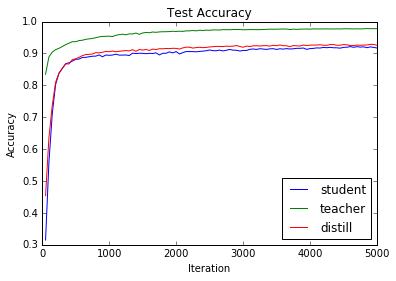

In [10]:
log_list = ['student', 'teacher', 'distill']
acc_list = []
for log_name in log_list:
    log_file = sorted(glob.glob(os.path.join(out_dir, log_name + '*.csv')))[-1]
    with open(log_file, 'r') as f:
        lines = f.readlines()
    test_acc = [float(line.split(',')[-1]) for line in lines]
    iter = [float(line.split(',')[0]) for line in lines]
    acc_list.append(test_acc)
    plt.plot(iter, test_acc, label = log_name)
plt.legend(loc = 'lower right')
plt.title('Test Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.show()
